# Fit Picaso Atmosphere Grid Models to Juliet Transmission Spectrum

Original Picaso Tutorial:
https://natashabatalha.github.io/picaso/notebooks/fitdata/GridSearch.html?highlight=grid%20search

## Changes to Picaso after Install

In fit_grid fucntion replace line 290\
xw , flux_in_bin = mean_regrid(self.wavelength[grid_name],self.spectra[grid_name][index,:],newx= wlgrid_center) \
with\
xw , flux_in_bin = wlgrid_center,self.spectra[grid_name][index,:][::-1]

This will replace model wavelenth with juliet wavelenths, and reverse the data to be in the same order as juliet\

In detection_test function replace line 600\
nwo, model_exclude = mean_regrid(wno,model_exclude,newx=np.sort(1e4/wlgrid_center))\
with\
wno, model_exclude  = df['wavenumber'] , df['transit_depth']\


I analyze line 602/603:
MV # wno, model_exclude = mean_regrid(wno,model_exclude,newx=np.sort(1e4/wlgrid_center))
wno, model_exclude = mean_regrid(wno,model_exclude,R=78.2)#MV #

comment 583
#MV        wavelength, model_full = mean_regrid(wavelength,model_full,newx=wlgrid_center)
627: replace     residual_data = y_data-model_exclude with 
    residual_data = y_data.values-model_exclude
630:         ax[1].errorbar(wlgrid_center, residual_data, yerr=e_data.values,fmt='ok',label='Residual in data')

In [1]:
import os
os.environ['PYSYN_CDBS']="/home/maria/picaso/grp/redcat/trds/"
os.environ["picaso_refdata"] ="/home/maria/picaso/reference"

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
import numpy as np
import os
import pandas as pd
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import picaso.analyze as lyz
jpi.output_notebook()
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
path ="/home/maria/trappist1c"

Loading BokehJS ...

## JWST Juliet Reduction

In [ ]:
jwst_reduction=pd.read_csv(os.path.join(path,"jwst/w_depths_with_errors.csv"))
#jwst_reduction=jwst_reduction[jwst_reduction['d']<1.0e+06]
data=jwst_reduction['d']
jwst_reduction["dd"]=(data - np.min(data)) / (np.max(data) - np.min(data))
jwst_reduction["dm"]=jwst_reduction["d"]/np.median(jwst_reduction["d"])


In [ ]:
data=jwst_reduction["s15"]
jwst_reduction["s15"]=(data - np.min(data)) / (np.max(data) - np.min(data))
data=jwst_reduction["s25"]
jwst_reduction["s25"]=(data - np.min(data)) / (np.max(data) - np.min(data))
data=jwst_reduction["s50"]
jwst_reduction["s50"]=(data - np.min(data)) / (np.max(data) - np.min(data))
data=jwst_reduction["s75"]
jwst_reduction["s75"]=(data - np.min(data)) / (np.max(data) - np.min(data))
data=jwst_reduction["s100"]
jwst_reduction["s100"]=(data - np.min(data)) / (np.max(data) - np.min(data))
data=jwst_reduction["s85"]
jwst_reduction["s85"]=(data - np.min(data)) / (np.max(data) - np.min(data))

## Filter outliers

In [ ]:
plt.figure(figsize=(12, 5))
s=jwst_reduction[jwst_reduction['d']<4000000]
s=jwst_reduction[jwst_reduction['d']>1000000]
plt.plot(s['w'], s['s25'])
plt.plot(s['w'], s['s50'])
plt.plot(s['w'], s['s75'])
plt.plot(s['w'], s['s85'])
plt.plot(s['w'], s['s100'])
plt.plot(s['w'], s['d'])

## Binned Reduction

In [ ]:
plt.figure(figsize=(12, 5))
sm=s[s['d']>1000000]
sm=sm[sm['d']<4000000]
sm['sm15']=(median_filter(sm["d"], 15000))
sm['sm15err']=(median_filter(sm["err"], 15000))
sm['sm25']=(median_filter(sm["d"], 25000))
sm['sm25err']=(median_filter(sm["err"], 25000))
sm['sm50']=(median_filter(sm["d"], 50000))
sm['sm50err']=(median_filter(sm["err"], 50000))
sm.to_csv("fileterd_bins_results.csv")

## Define Paths To Data and Models

In [3]:
sm=pd.read_csv("fileterd_bins_results.csv")

plt.figure(figsize=(12, 5))
plt.errorbar(wlgrid_center,rprs_data2,
                yerr=e_rprs2*.5,
                 fmt='o', alpha=0.3)
plt.plot(model5[0],model5[1], alpha =.5)

<ErrorbarContainer object of 3 artists>

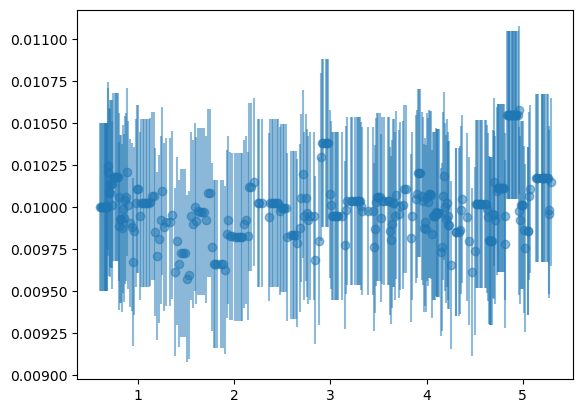

In [4]:
#sm['sm2']=(median_filter(sm['sm15'], 5))
smm=sm.groupby("w").mean()
wlgrid_center =list(smm.index)
rprs_data2 = np.log2(smm['sm15'])*.005
e_rprs2 = np.log2(smm['sm15err'])*.000001
reduction_name = "Picaso"
wlgrid_width=[]
init=min(wlgrid_center)
for i in wlgrid_center[1:]:
    wlgrid_width.append(i-init)
    init=i
rprs_data2=rprs_data2
rprs_data2=(smm['sm15']/ np.median(smm['sm15']))*.01#+.005
e_rprs2 = (smm['sm15err']/smm['sm15err'])*.0005
plt.errorbar(wlgrid_center,(rprs_data2),
                yerr=e_rprs2,
                 fmt='o', alpha=0.5)

<ErrorbarContainer object of 3 artists>

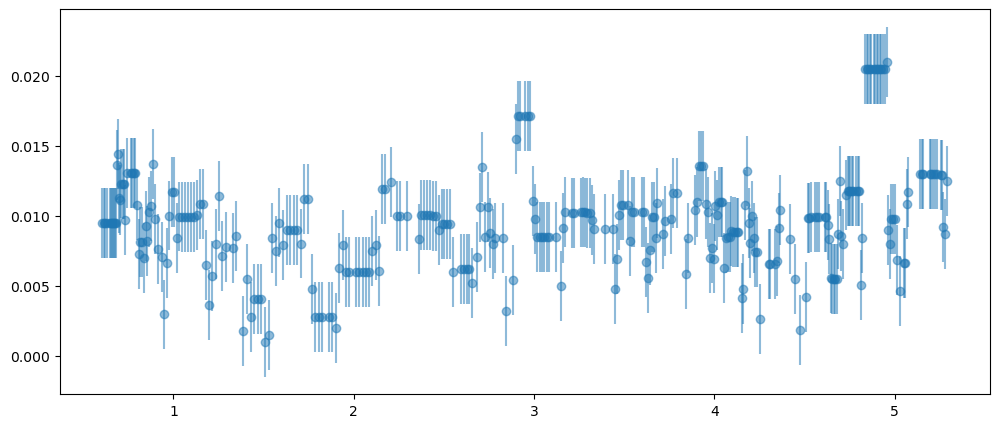

In [5]:
rprs_data2p=(smm['sm15']/ np.median(smm['sm15']))
e_rprs2p = (smm['sm15err']/smm['sm15err'])*.005
plt.figure(figsize=(12, 5))
plt.errorbar(wlgrid_center,(rprs_data2p*.2)-.1905,
                yerr=e_rprs2p*.5,
                 fmt='o', alpha=0.5)
#plt.plot(model5[0],model5[1],alpha=0.2)

In [ ]:
rprs_data2.shape

In [ ]:
sm.head()

## Add Available Grids to Test

First step will be to load your first grid into the `GridFitter` class. You can do this easily by supplying the function a directory location, and grid name (`grid_name`). 

The only purpose of `grid_name` is in case you add more grids to your `GridFitter` function, it will be easy to keep track of what parameters go with what grid.  

In [77]:
grid_name = "picaso_cldy"
location = os.path.join(path,"models/cloudy")
fitter = lyz.GridFitter(grid_name,location, verbose=True)

Total number of models in grid is 1429
For tint in planet_params grid is: [1640. 1660. 1680.]
For mh in planet_params grid is: [0.05 0.1  0.2  0.3  0.5 ]
For cto in planet_params grid is: [0.01 0.1  0.3  0.5  0.7  1.  ]
For feh in stellar_params grid is: [0.   0.04]
For fsed in cld_params grid is: [ 0.  7.  9. 11. 15. 18.]


This shows you what parameters the grid was created over

In [78]:
location = os.path.join(path,"models/cloud_free")
fitter.add_grid('picaso_cld_free', location)#

Total number of models in grid is 304
For tint in planet_params grid is: [1640. 1660. 1680.]
For mh in planet_params grid is: [0.05 0.1  0.2  0.3  0.5 ]
For cto in planet_params grid is: [0.01 0.1  0.3  0.5  0.7  1.  ]


## Add Juliet Reduction

Though the models are interesting, what we are really after is which is most representative of the data. So now let's add some datasets to explore. 

In [79]:
fitter.add_data('juliet',wlgrid_center, wlgrid_width, rprs_data2, e_rprs2)

## Compute $\chi_{red}^2$/N and Retrieve Single Best Fit

In this analysis we used the reduced chi sq per data point as a metric to fit the grid. This fitter function will go through your whole grid and compute cross reference the chi sq compared to your data. 

In [80]:
fitter.fit_grid('picaso_cldy','juliet')
fitter.fit_grid('picaso_cld_free','juliet')


Now that we have accumulated results let's turn this into a dictionary to easily see what we've done

In [81]:
out = fitter.as_dict()#allows you to easily grab data
print("Cloudy: " ,out['rank_order']['picaso_cldy']['juliet'][0:5])
print("Cloud Free: " ,out['rank_order']['picaso_cld_free']['juliet'][0:5])

Cloudy:  [ 747 1164  741  742  743]
Cloud Free:  [ 70 136 137 138 222]


We are most interested in the models with the best reduced chi sq. We can use our ranked order to get the models that best fit the data. 

### Use rank order to get the top best fit or other parameters
#top 5 best fit models metallicities for the cloud free grid
print("cld free",np.array(out['grid_params']['picaso_cld_free']['planet_params']['mh']
        )[out['rank_order']['picaso_cld_free']['juliet']][0:5])

#top 5 best fit models metallicities for the cloudy grid
print("cldy",np.array(out['grid_params']['picaso_cldy']['planet_params']['mh']
        )[out['rank_order']['picaso_cldy']['juliet']][0:5])

Let's look at the associated chi square values. 

#top 5 best fit chi sqs for the cloud free grid
print("cld free", np.array(out['chi_sqs']['picaso_cld_free']['juliet']
        )[out['rank_order']['picaso_cld_free']['juliet']][0:5])
      
#top 5 best fit chi sq for the cloudy grid
print("cldy", np.array(out['chi_sqs']['picaso_cldy']['juliet']
        )[out['rank_order']['picaso_cldy']['juliet']][0:5])

The cloudy grid is giving lower chi square giving us clues that this planet likely has clouds affecting the spectrum.

## Analyze Single Best Fits

Let's analyze the single best fits in order to compare the spectrum with the data

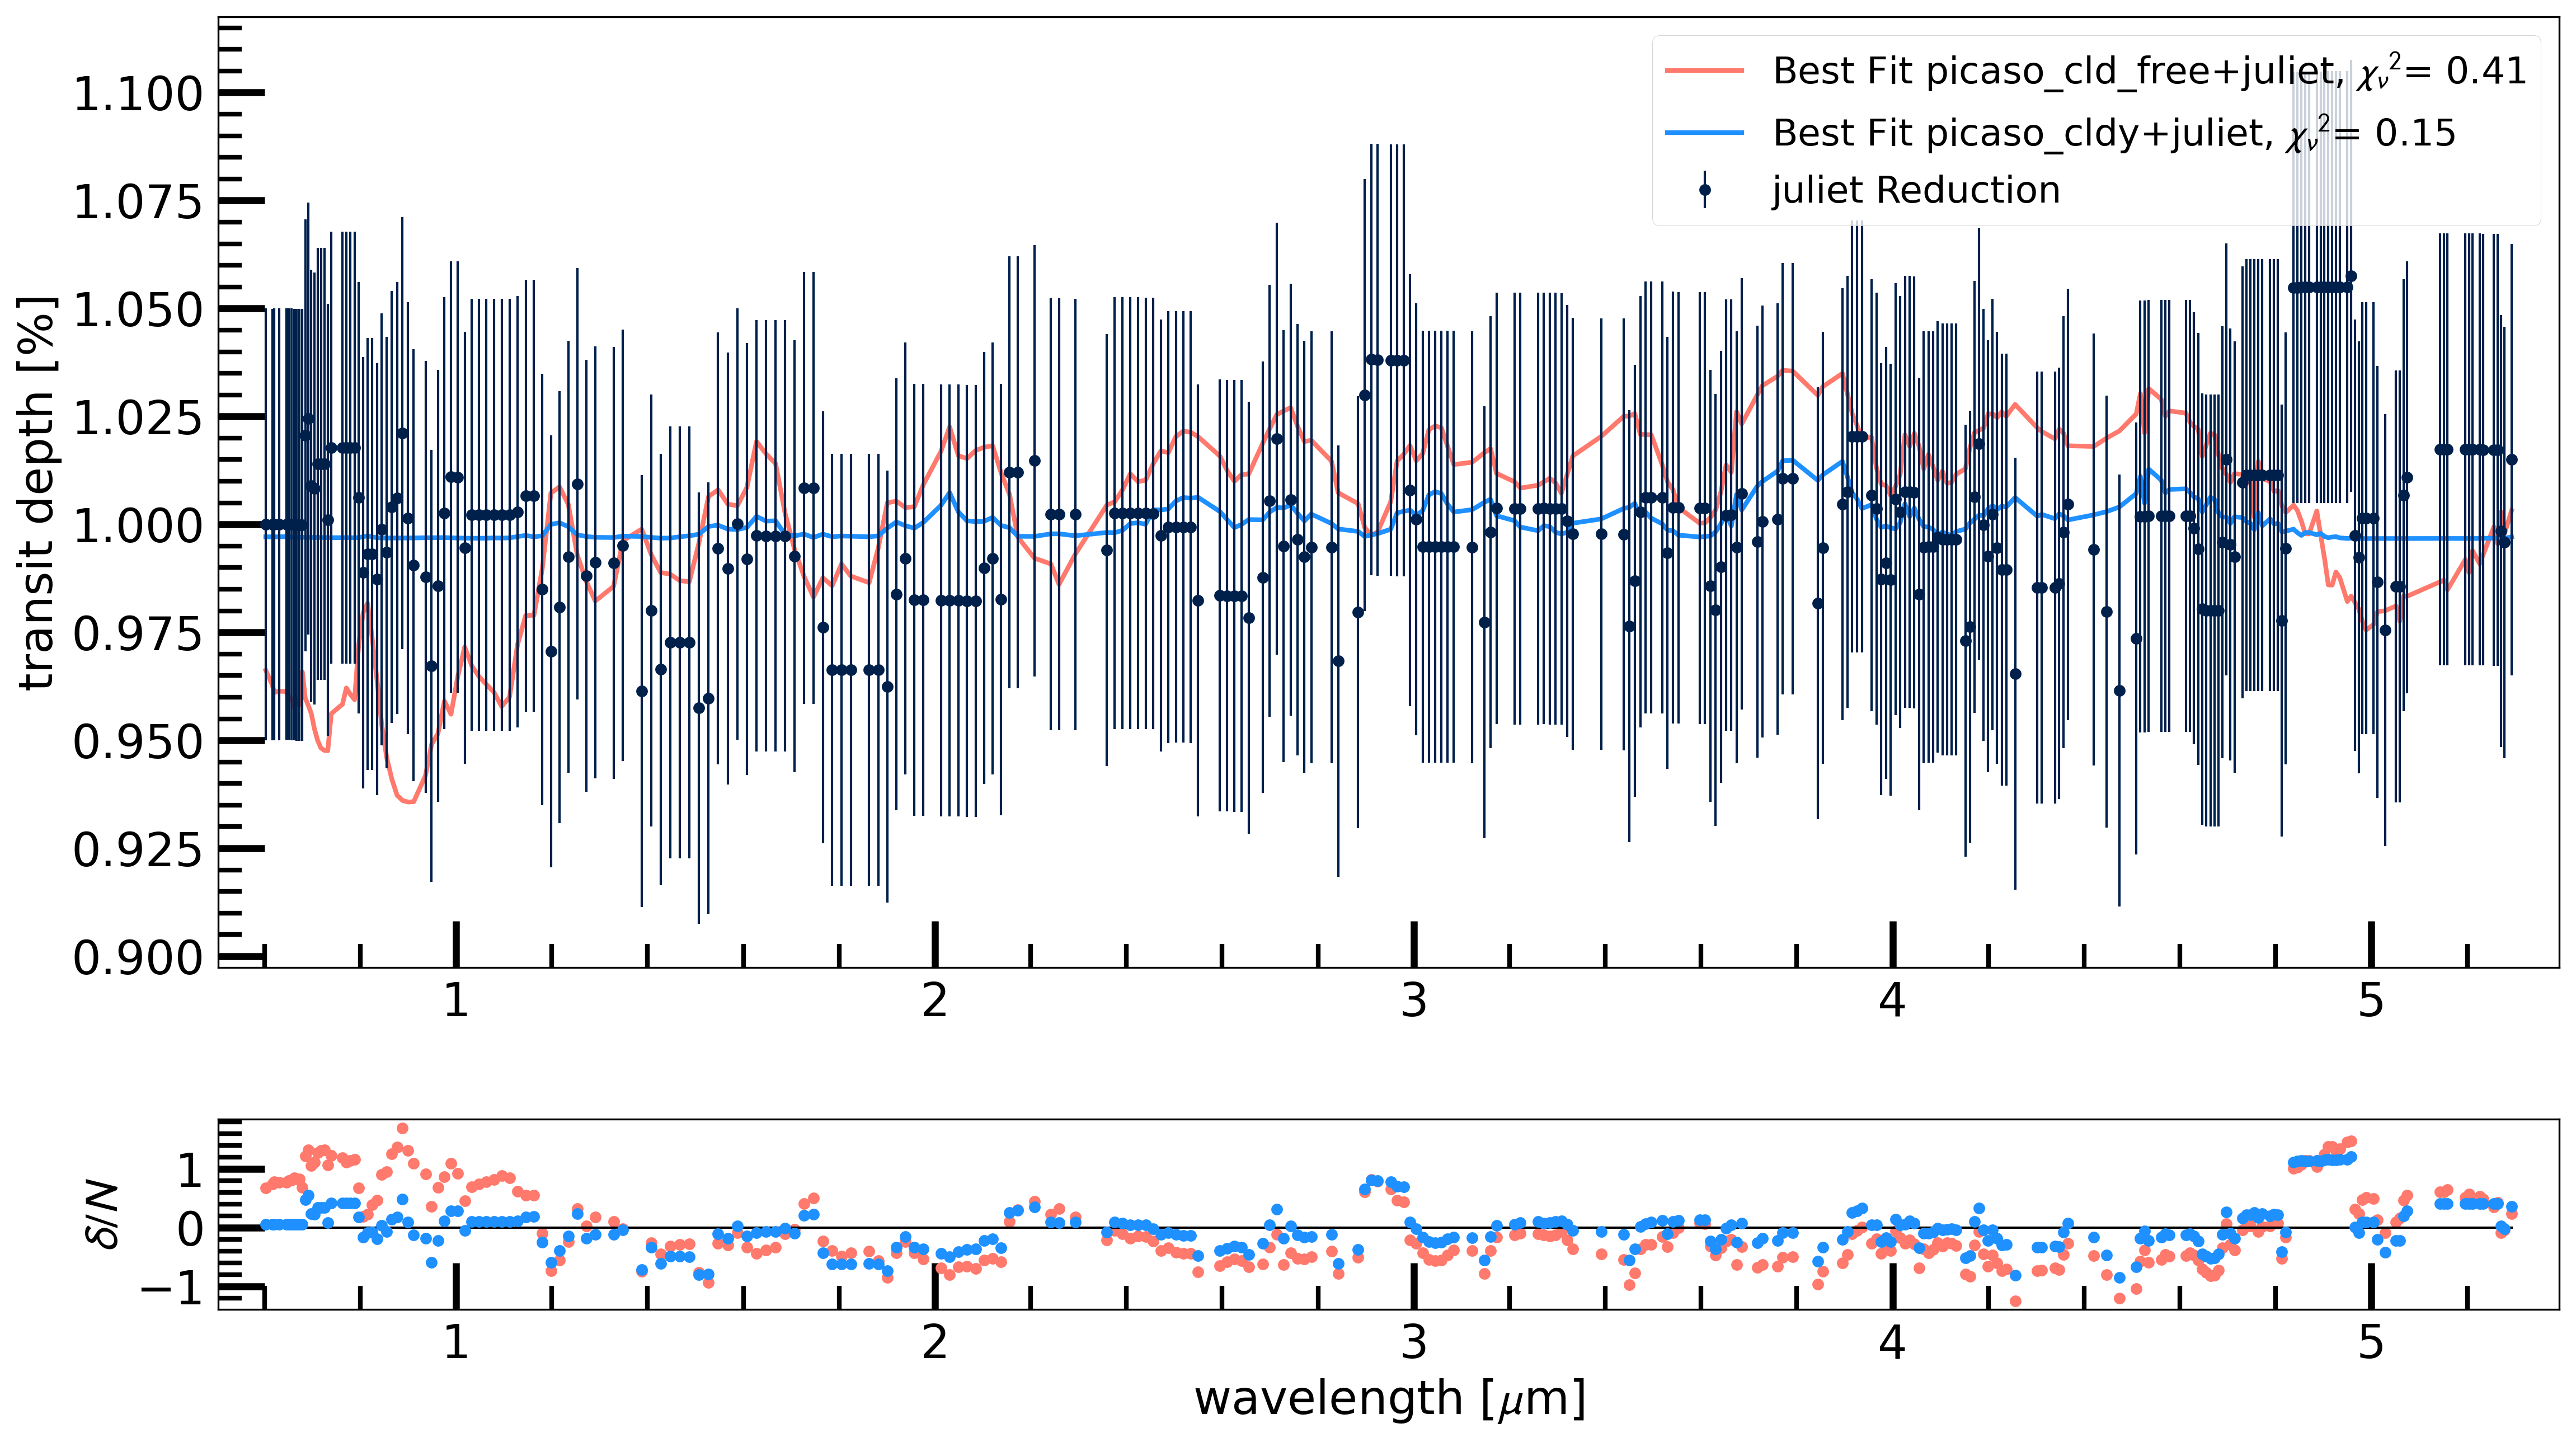

In [82]:
fig,ax = fitter.plot_best_fit(['picaso_cld_free','picaso_cldy'],'juliet')

The cloudy grid is giving a much better representation of the data. Let's look at what physical parameters are associated with this. 

In [83]:
best_fit = fitter.print_best_fit('picaso_cldy','juliet')

tint=1660.0
mh=0.05
cto=0.01
feh=0.04
fsed=7.0


In [84]:
fitter.print_best_fit('picaso_cld_free','juliet')

tint=1680.0
mh=0.5
cto=0.01


{'tint': 1680.0, 'mh': 0.5, 'cto': 0.01}

You can see these same parameters reported in original Nature paper: https://arxiv.org/pdf/2208.11692.pdf

## Estimated Posteriors 

It is also helpful to get an idea of what the probability is for each grid parameter in your model. This will give you a better representation of degeneracies that exist with your data and each of your physical parameters. 

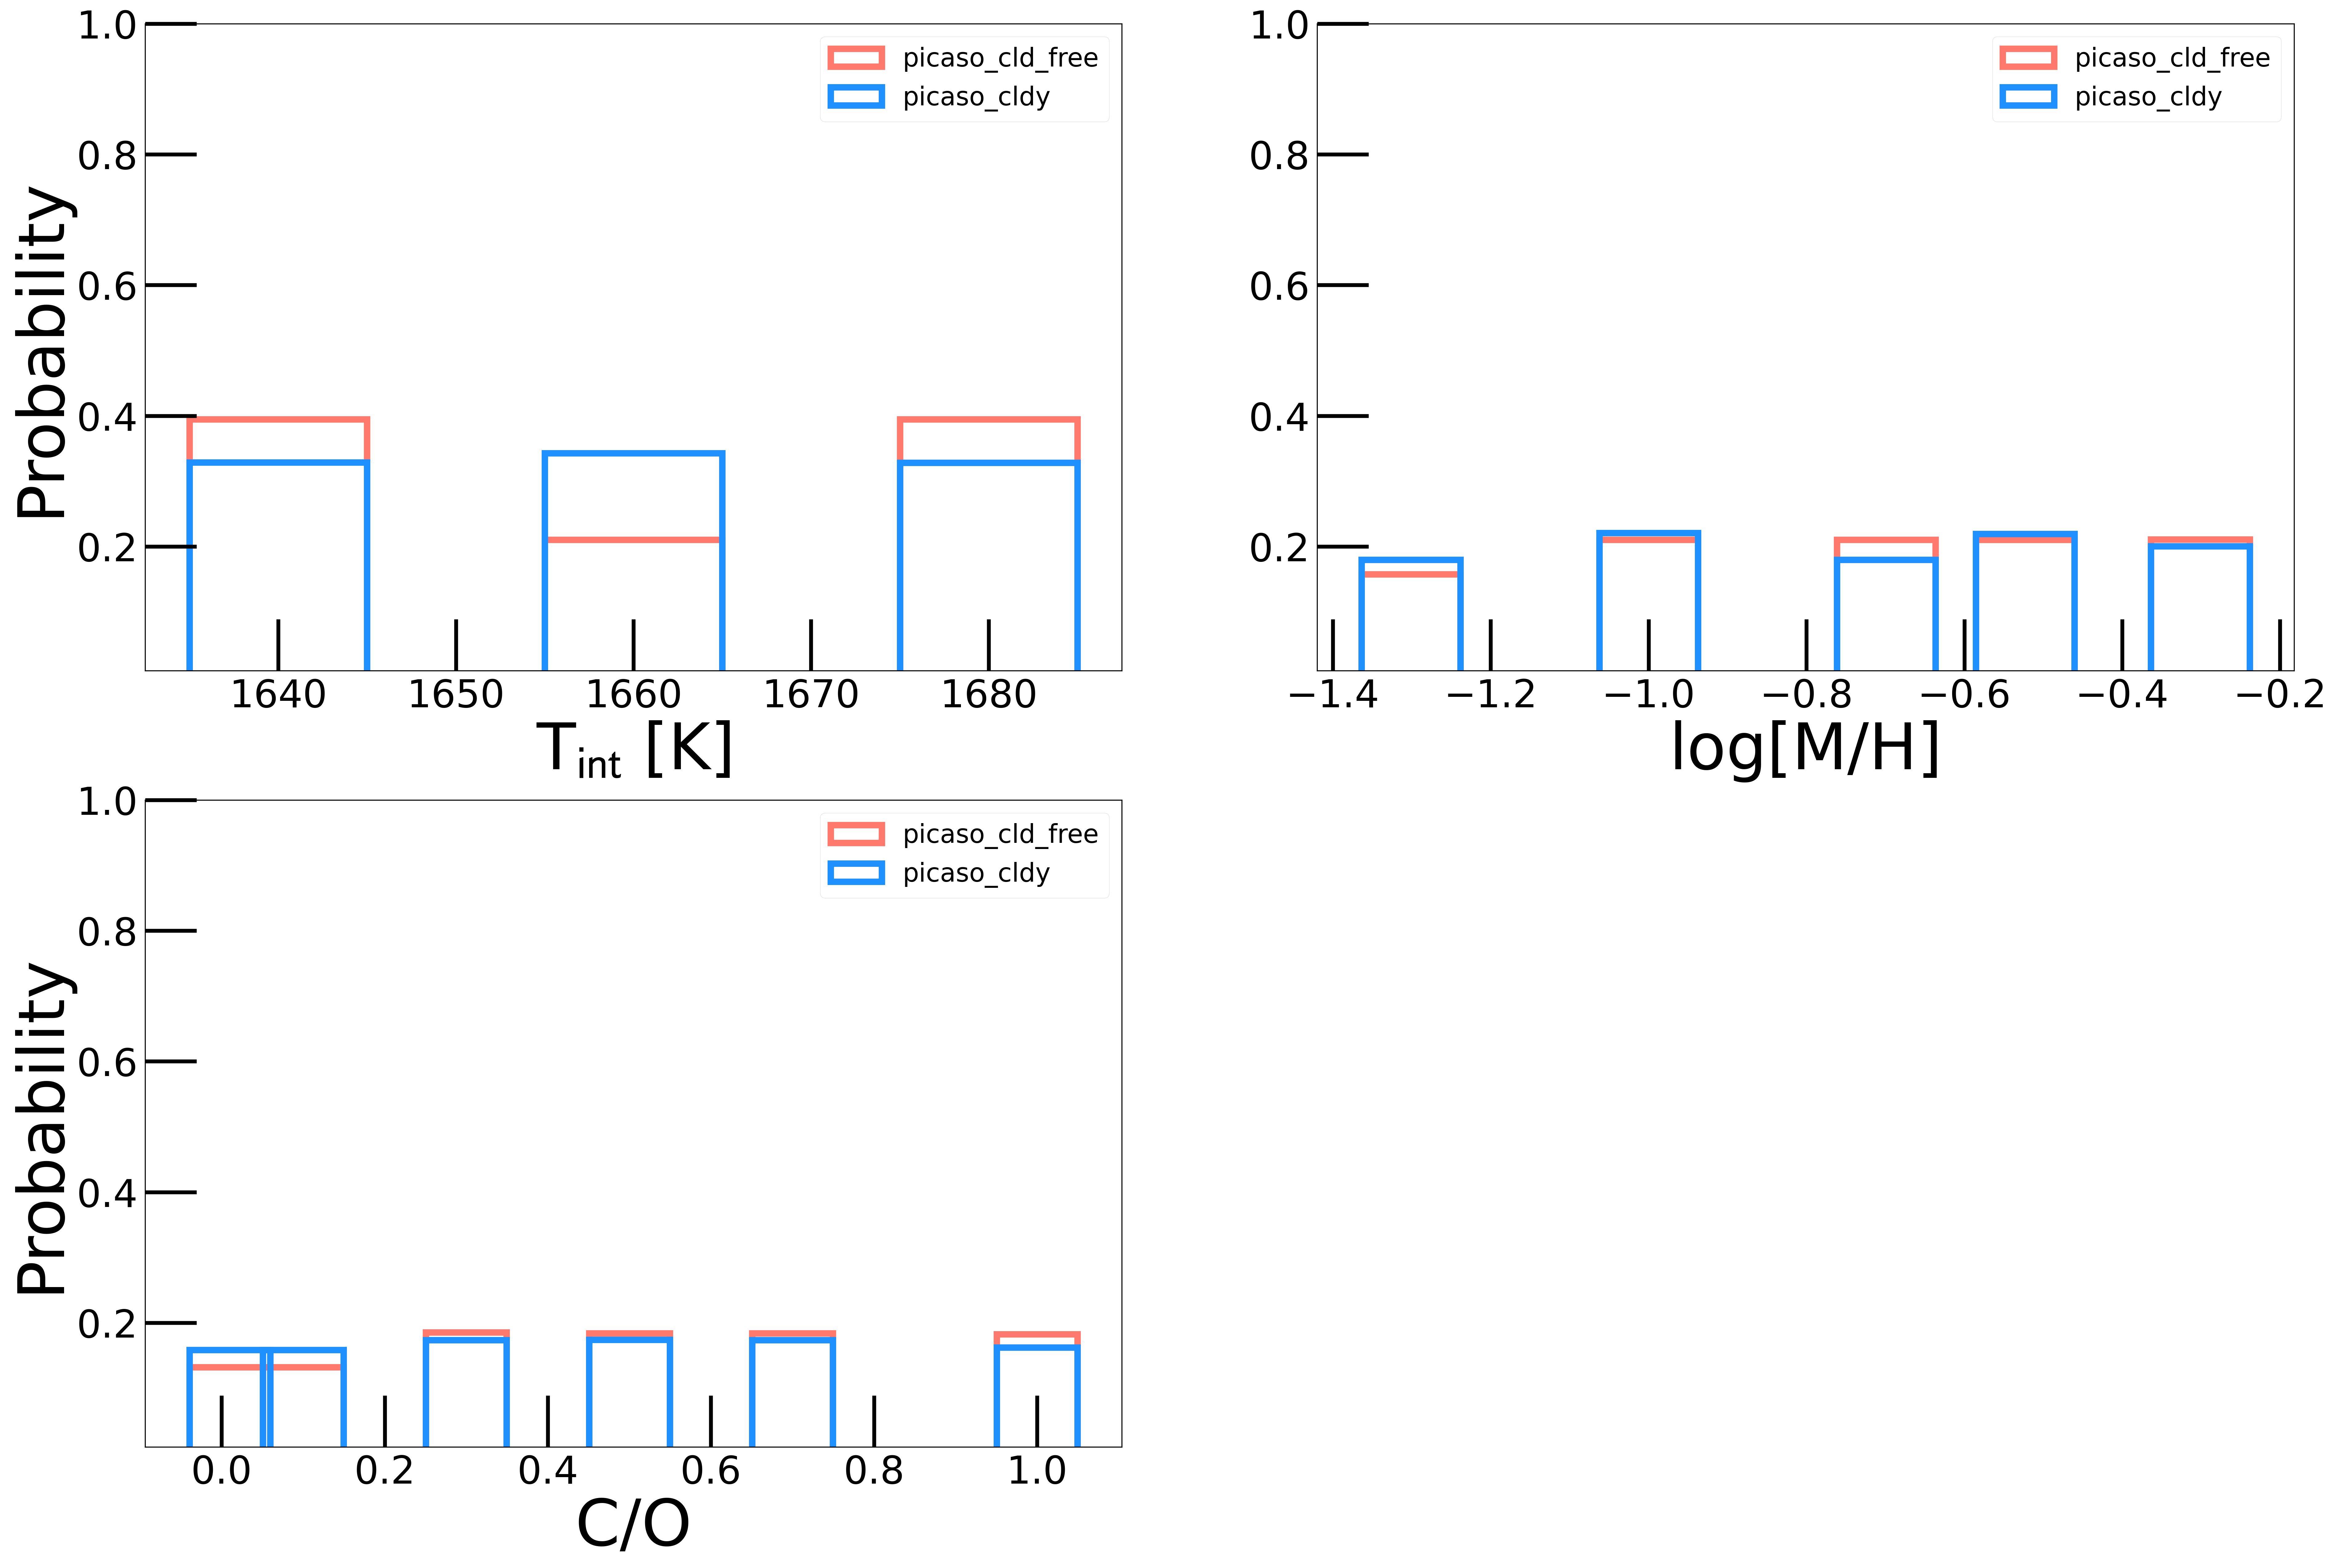

In [85]:
f,a=fitter.plot_posteriors('picaso_cld_free','juliet',['tint','mh','cto'], 
               x_label_style={'tint':r"T$_{\rm int}$ [K]",
                              'mh':"log[M/H]", 'cto':r"C/O"}, 
               x_axis_type={'tint':r"linear",
                              'mh':"log", 'cto':r"linear"})
f,a=fitter.plot_posteriors('picaso_cldy','juliet',['tint','mh','cto'], 
               x_label_style={'tint':r"T$_{\rm int}$ [K]",
                              'mh':"log[M/H]", 'cto':r"C/O"}, 
               x_axis_type={'tint':r"linear",
                              'mh':"log", 'cto':r"linear"}, fig=f, ax=a)

What can you take away from this plot? 
1. Cloudy models reduce the number of models that can be fit to the data with high metallicity
2. Internal temperature cannot be constrained by the data 
3. C/O ratios greater than ~0.8 can be ruled out by the data

## Interpret Best Fit

Now that we are happy with the best-fitting model, we can load in that data and post process some plots in order to gain better understanding of our results.

We can use `PICASO`'s `xarray` loader to quickly load in one of our models. 

In [90]:
#grab top model 

top_model_file  = np.array(out['list_of_files']['picaso_cldy']
        )[out['rank_order']['picaso_cldy']['juliet']][0:5]

#xr_usr = jdi.xr.load_dataset(top_model_file)

In [91]:
top_model_file

array(['/home/maria/trappist1c/models/cloudy/trappist1c_model_cloundy[350, 7, 0.05, 1660, 0.01].nc',
       '/home/maria/trappist1c/models/cloudy/trappist1c_model_cloundy[360, 7, 0.1, 1640, 0.01].nc',
       '/home/maria/trappist1c/models/cloudy/trappist1c_model_cloundy[350, 7, 0.05, 1640, 0.01].nc',
       '/home/maria/trappist1c/models/cloudy/trappist1c_model_cloundy[350, 7, 0.05, 1640, 0.1].nc',
       '/home/maria/trappist1c/models/cloudy/trappist1c_model_cloundy[350, 7, 0.05, 1640, 0.3].nc'],
      dtype='<U91')

In [88]:
np.array(out['list_of_files']['picaso_cld_free']
        )[out['rank_order']['picaso_cld_free']['juliet']][0:5]

array(['/home/maria/trappist1c/models/cloud_free/trappist1c_model_cloundfree[340, 0.5, 1680, 0.01].nc',
       '/home/maria/trappist1c/models/cloud_free/trappist1c_model_cloundfree[350, 0.5, 1640, 0.01].nc',
       '/home/maria/trappist1c/models/cloud_free/trappist1c_model_cloundfree[350, 0.5, 1640, 0.1].nc',
       '/home/maria/trappist1c/models/cloud_free/trappist1c_model_cloundfree[350, 0.5, 1640, 0.3].nc',
       '/home/maria/trappist1c/models/cloud_free/trappist1c_model_cloundfree[360, 0.5, 1680, 0.01].nc'],
      dtype='<U94')

In [89]:
xr_usr=jdi.xr.load_dataset(top_model_file[0])
xr_usr

<xarray.Dataset>
Dimensions:        (pressure: 90, wavelength: 301)
Coordinates:
  * pressure       (pressure) float64 0.0001938 0.0002304 ... 229.4 273.9
  * wavelength     (wavelength) float64 1.889e+03 1.902e+03 ... 1.661e+04
Data variables: (12/40)
    temperature    (pressure) float64 101.9 102.8 103.1 ... 2.629e+03 2.738e+03
    transit_depth  (wavelength) float64 0.007497 0.007494 ... 0.007497 0.007498
    H2             (pressure) float64 0.8369 0.8369 0.8369 ... 0.8349 0.8348
    H              (pressure) float64 4.505e-38 4.505e-38 ... 0.002633 0.00366
    H+             (pressure) float64 4.505e-38 4.505e-38 ... 7.008e-21
    H-             (pressure) float64 4.505e-38 4.505e-38 ... 1.892e-09
    ...             ...
    Li             (pressure) float64 4.505e-38 4.505e-38 ... 2.412e-09
    LiOH           (pressure) float64 4.505e-38 4.505e-38 ... 1.732e-10
    LiH            (pressure) float64 4.505e-38 4.505e-38 ... 1.193e-09
    LiCl           (pressure) float64 4.505e-38 4.505e-38 ... 4.508e-12
    Al             (pressure) float64 7.297e-57 6.194e-57 ... 1.858e-06
    CaH            (pressure) float64 7.297e-57 6.194e-57 ... 4.727e-07
Attributes:
    author:          D Vaida
    contact:         dvaida28@gmail.com
    code:            numpy
    doi:             
    planet_params:   {"rp": {"value": 0.09421, "unit": "jupiterRad"}, "pteff"...
    stellar_params:  {"rs": {"value": 0.12, "unit": "solRad"}, "logg": 5, "st...
    orbit_params:    {"sma": 0.01521}
    cld_params:      {"opd": "None", "ssa": "None", "asy": "None", "p_cloud":...

In [36]:

opa = jdi.opannection(wave_range=[.6,5.5])
case = jdi.input_xarray(xr_usr, opa)
#if you need to rerun your spectrum 
#out = case.spectrum(opa,calculation='transmisson')

### See Contribution From Each Molecule

One of the most common plots that was also used in the original paper is the "leave one out" method to see how each molecule is affecting our spectrum. 

In [37]:
og_atmo = jdi.copy.deepcopy(case.inputs['atmosphere']['profile'])
og_atmo.columns

Index(['pressure', 'temperature', 'H2', 'H', 'H+', 'H-', 'H2-', 'H2+', 'H3+',
       'He', 'H2O', 'CH4', 'CO', 'NH3', 'N2', 'PH3', 'H2S', 'TiO', 'VO', 'Fe',
       'FeH', 'CrH', 'Na', 'K', 'Rb', 'Cs', 'CO2', 'HCN', 'C2H2', 'C2H4',
       'C2H6', 'SiO', 'MgH', 'OCS', 'Li', 'LiOH', 'LiH', 'LiCl', 'Al', 'CaH'],
      dtype='object')

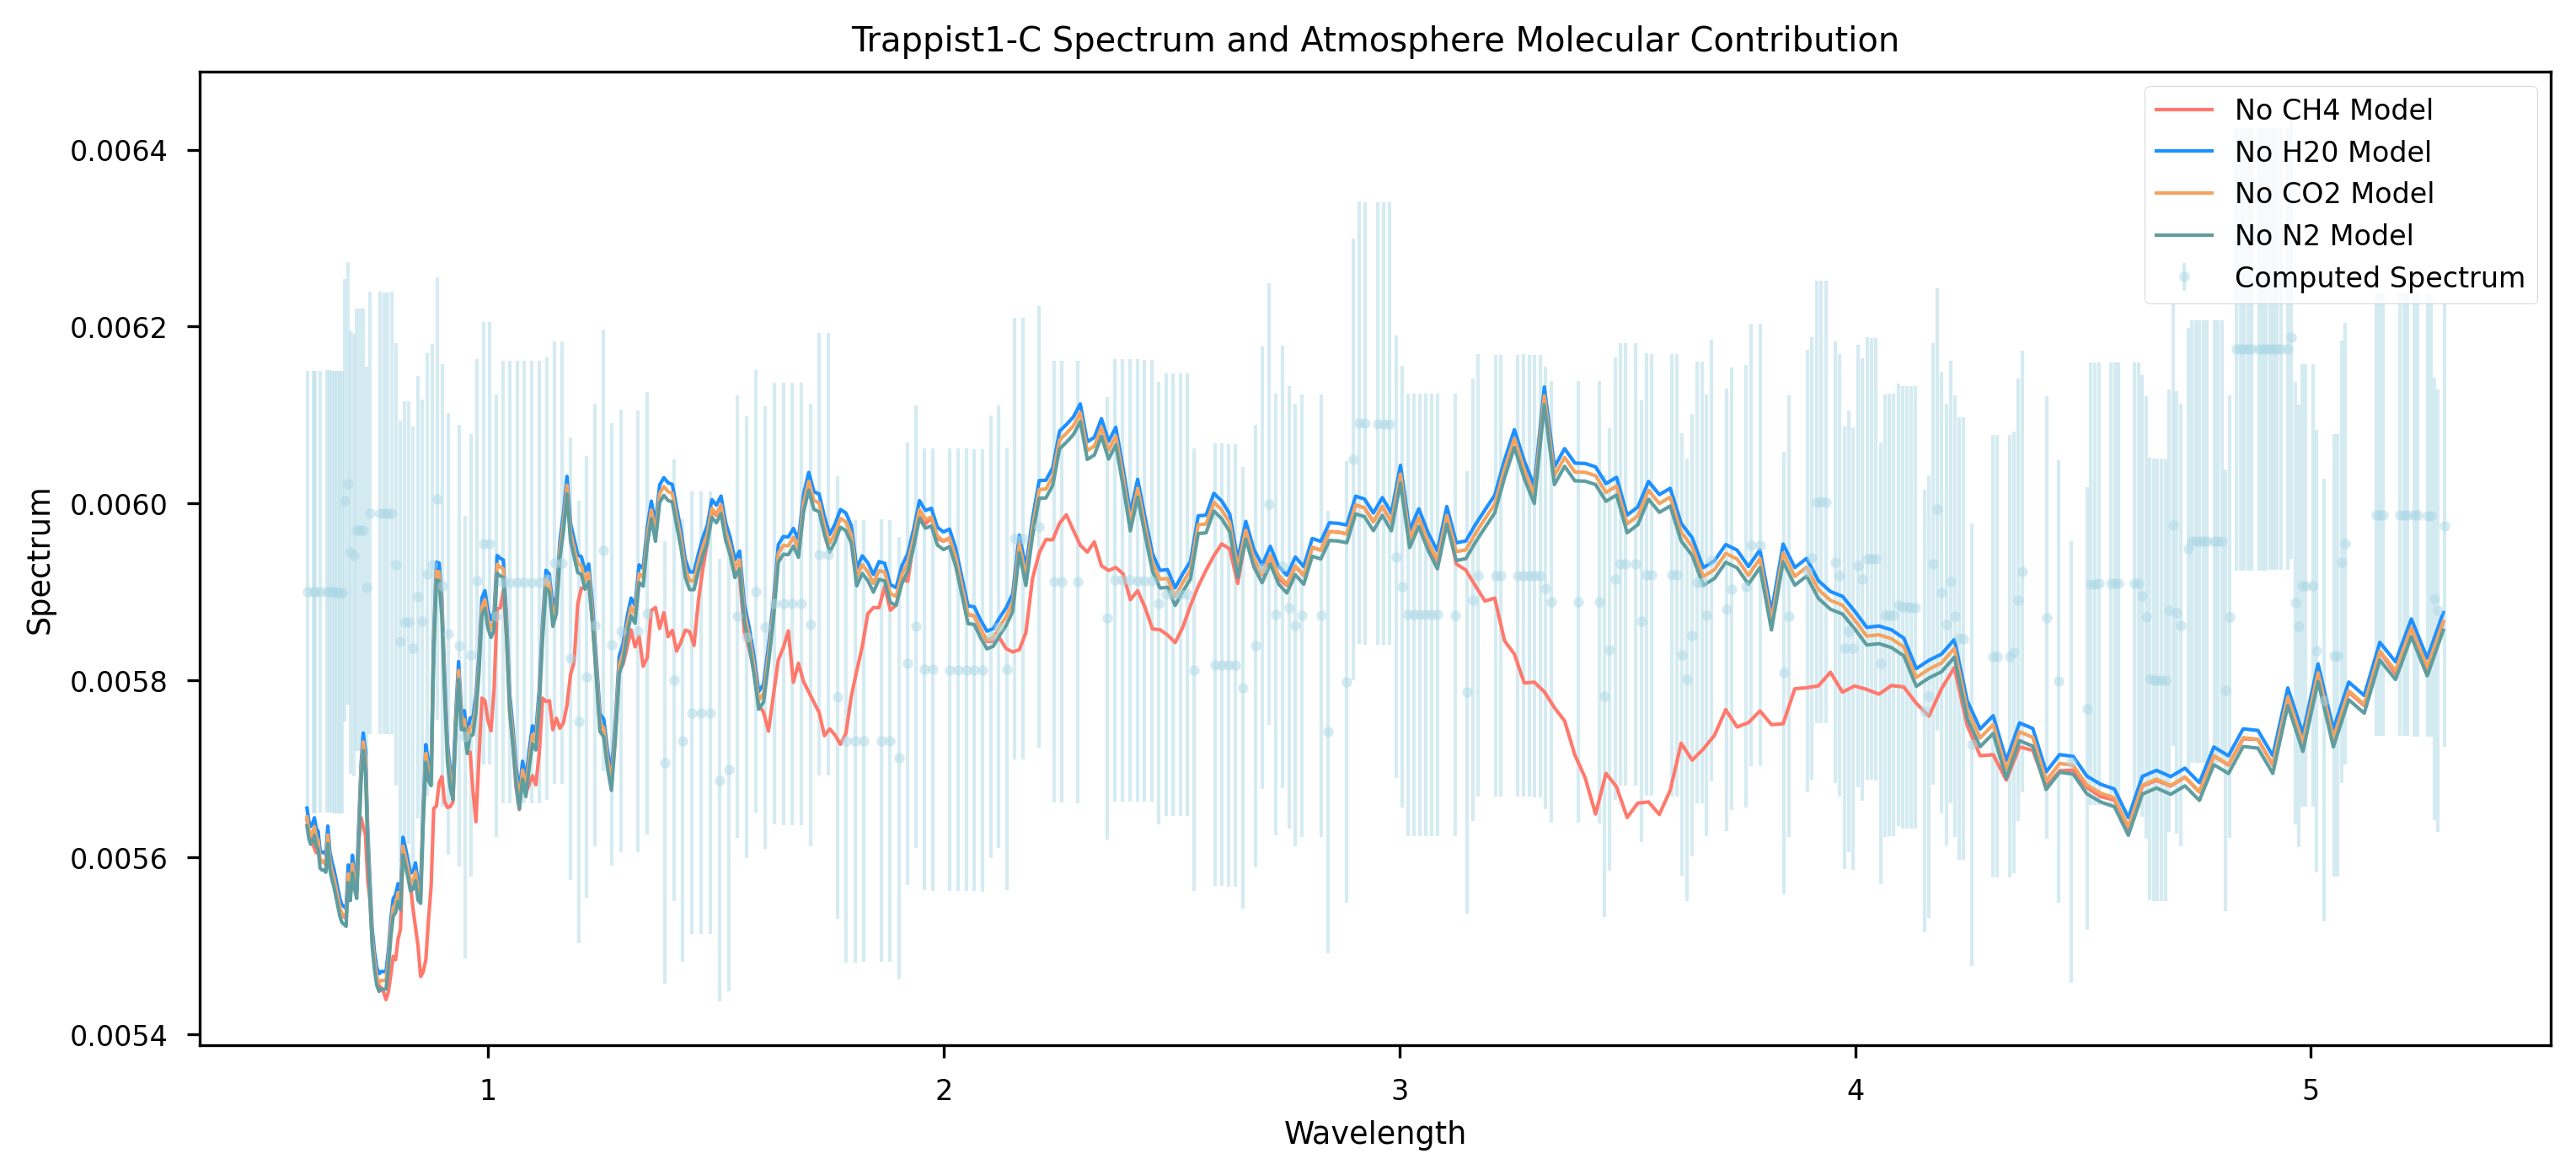

In [39]:
import matplotlib
#copy atmo before modifying and rerunning picaso
og_atmo = jdi.copy.deepcopy(case.inputs['atmosphere']['profile'])
#atmo
w,f,l =[],[],[]
for i, iex in enumerate([ "CH4", "H20", "CO2", "N2"]):
#for iex in [ 'FeH', 'CrH', 'Na', 'K', 'Rb', 'Cs', 'CO2', 'H2O', None]:    
    
    case.atmosphere(df = og_atmo,exclude_mol=iex, delim_whitespace=True)
    df= case.spectrum(opa, full_output=True,calculation='transmission') #note the new last key 
    wno, rprs2  = df['wavenumber'] , df['transit_depth']
    wno, rprs2 = jdi.mean_regrid(wno, rprs2, R=150)
    ww=pd.DataFrame(1e4/wno)
    ww=ww[ww[0]<5.3]
    rr=pd.DataFrame(rprs2)
    rr=rr.iloc[list(ww.index.values)]
    w +=[ww]
    f+=[rr]
    if iex==None: 
        leg='all'
    else: 
        leg = f'No {iex}'
    l+=[leg]
model10 = pd.read_table(os.path.join(path,"models/exotek_model19.dat"), sep="\s+",header=None)
model10=model10[model10[0]<=5.5]
model10=model10[model10[0]>=.6]
plt.figure(figsize=(12, 5))
plt.errorbar(wlgrid_center,(rprs_data2)/2+.0009,
                yerr=e_rprs2*.5,
                 fmt='o', alpha=0.5, label = 'Computed Spectrum', color = "lightblue")
#plt.plot(model10[0],model10[1], label = 'ExoCTK Model')
plt.plot(w[0],f[0]/2+.0015, label = 'No CH4 Model')
plt.plot(w[1], f[1]/2+.00151, label = 'No H20 Model')
plt.plot(w[2],f[2]/2+.0015, label = 'No CO2 Model')
plt.plot(w[3], f[3]/2+.00149, label = 'No N2 Model')
#plt.plot(w[4], f[4]/2+.0015, label = 'All Model')
plt.ylabel("Spectrum")
plt.xlabel("Wavelength")
plt.title("Trappist1-C Spectrum and Atmosphere Molecular Contribution")
plt.legend()